# PS1

## MACS 30250, Dr. Evans
## Yiqing Zheng

## Problem 1
(a)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv('data\COVIDincubation.txt')
df.head()

,gender,age,symp_days
0,F,52.0,5.0
1,M,42.0,6.5
2,F,32.0,3.0
3,M,22.0,4.0
4,M,41.0,8.0


In [3]:
symp_days_tot = df['symp_days'].values

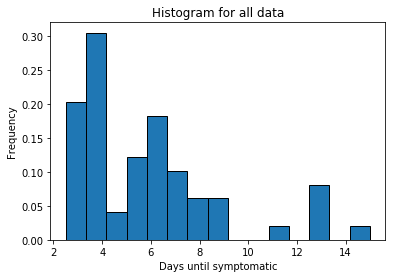

In [4]:
hist = plt.hist(symp_days_tot, bins=15, density=True, edgecolor='black')
plt.title("Histogram for all data")
plt.xlabel('Days until symptomatic')
plt.ylabel('Frequency');

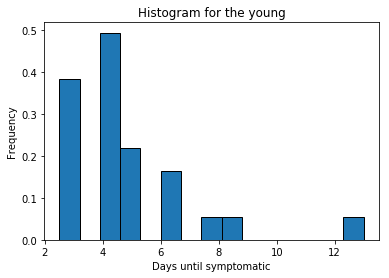

In [5]:
symp_days_young = df[df['age']<=40]['symp_days'].values
hist = plt.hist(symp_days_young, bins=15, density=True, edgecolor='black')
plt.title("Histogram for the young")
plt.xlabel('Days until symptomatic')
plt.ylabel('Frequency');

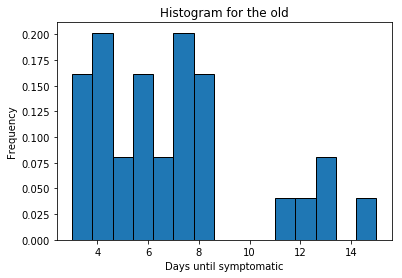

In [6]:
symp_days_old = df[df['age']>40]['symp_days'].values
hist = plt.hist(symp_days_old, bins=15, density=True, edgecolor='black')
plt.title("Histogram for the old")
plt.xlabel('Days until symptomatic')
plt.ylabel('Frequency');

(b)

In [2]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut

In [8]:
bandwidths = 10 ** np.linspace(-1, 1, 500)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                  {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(symp_days_tot.reshape(59,1));
opt_bandwidth_tot = grid.best_params_['bandwidth']
print(f'The best bandwidth for the total sample is {opt_bandwidth_tot}')
grid.fit(symp_days_young.reshape(len(symp_days_young),1));
opt_bandwidth_young = grid.best_params_['bandwidth']
print(f'The best bandwidth for the young sample is {opt_bandwidth_young}')
grid.fit(symp_days_old.reshape(len(symp_days_old),1));
opt_bandwidth_old = grid.best_params_['bandwidth']
print(f'The best bandwidth for the total sample is {opt_bandwidth_old}')

The best bandwidth for the total sample is 0.8910453324821516
The best bandwidth for the young sample is 1.6233824316122782
The best bandwidth for the total sample is 1.1861737164524786


In [9]:
# instantiate and fit the KDE model
opt_bandwidth = grid.best_params_['bandwidth']
kde_tot = KernelDensity(bandwidth=opt_bandwidth_tot, kernel='gaussian')
kde_tot.fit(symp_days_tot.reshape(59,1))
kde_young = KernelDensity(bandwidth=opt_bandwidth_young, kernel='gaussian')
kde_young.fit(symp_days_young.reshape(len(symp_days_young),1))
kde_old = KernelDensity(bandwidth=opt_bandwidth_old, kernel='gaussian')
kde_old.fit(symp_days_old.reshape(len(symp_days_old),1))

KernelDensity(algorithm='auto', atol=0, bandwidth=1.1861737164524786,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)

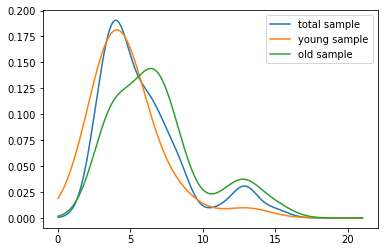

In [10]:
x_pts = np.linspace(0.01, 21, 1000).reshape(1000,1)
logprob_tot = kde_tot.score_samples(x_pts).reshape((1000,1))
logprob_young = kde_young.score_samples(x_pts).reshape((1000,1))
logprob_old = kde_old.score_samples(x_pts).reshape((1000,1))
plt.plot(x_pts, np.exp(logprob_tot), label='total sample')
plt.plot(x_pts, np.exp(logprob_young), label='young sample')
plt.plot(x_pts, np.exp(logprob_old), label='old sample')
plt.legend();

(c)
The incubation periods of young people are shorter than that of old people. For young people, if he is well for seven days, then the probability for him to have COV-19 is very low. For old people, even if he has been well for ten days, there still exists high probability for him to be not safe.

## Problem 2
(a)

In [3]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

In [4]:
bq_data = np.loadtxt('data\BQ_probmat.txt', delimiter=',')
bq_data.shape

(73, 7)

In [5]:
age_vec = np.arange(18, 91)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
# age_mat = np.tile(age_vec.reshpe((73,1)), (1,7))
# income_mat = np.tile(lambdas_mdpts.reshpe((1,7)), (73,1))
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

<IPython.core.display.Javascript object>


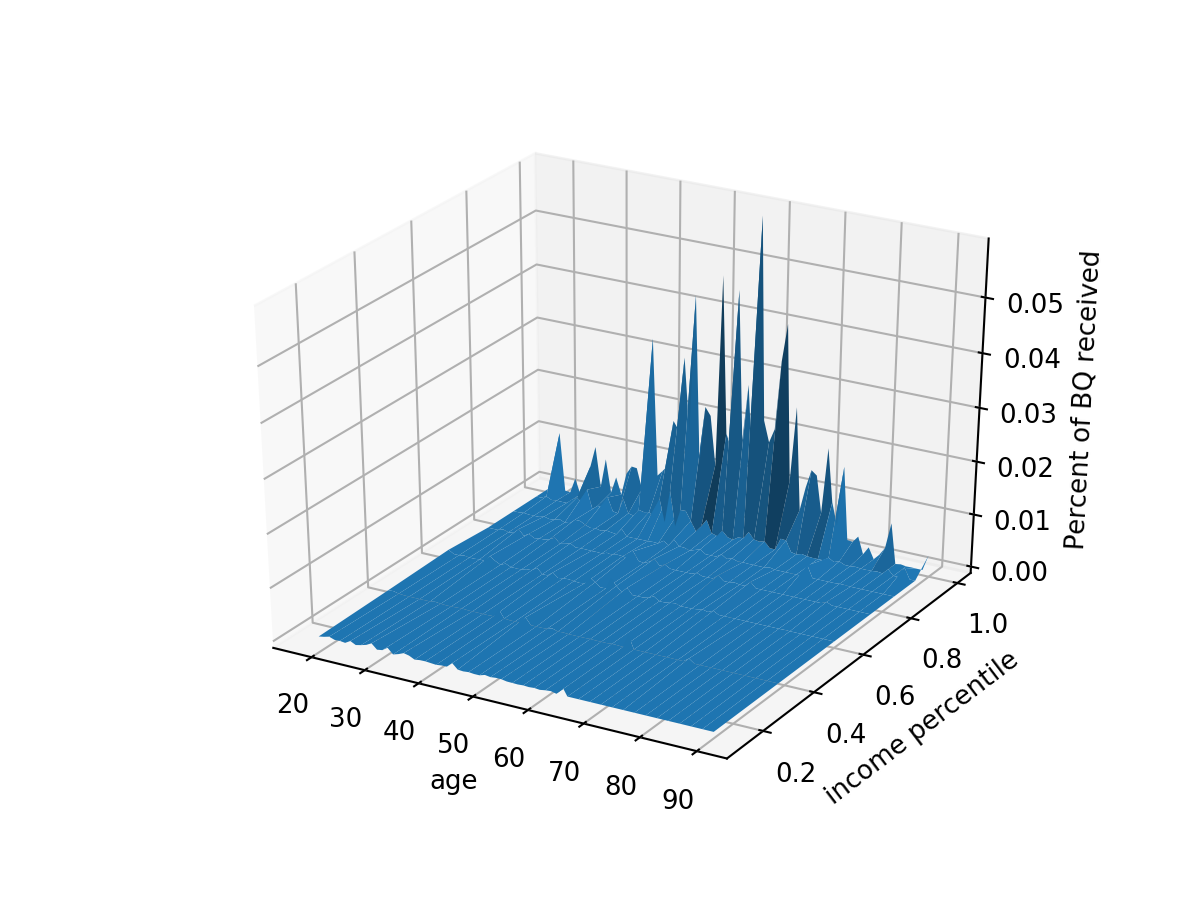

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_xlabel('age')
ax.set_ylabel('income percentile')
ax.set_zlabel('Percent of BQ received');

(b)

In [7]:
bq_ind_df = pd.read_csv('data\BQ_ind_data.txt')
bq_ind_df.head()

,age,income_pctl
0,18,0.125
1,18,0.125
2,18,0.125
3,18,0.125
4,18,0.125


In [8]:
bandwidth = 0.2
kde_density = gaussian_kde(bq_ind_df.T, bw_method=bandwidth)
coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
Z = np.reshape(kde_density(coords), age_mat.shape)
Z_scaled = Z / np.sum(Z)

<IPython.core.display.Javascript object>


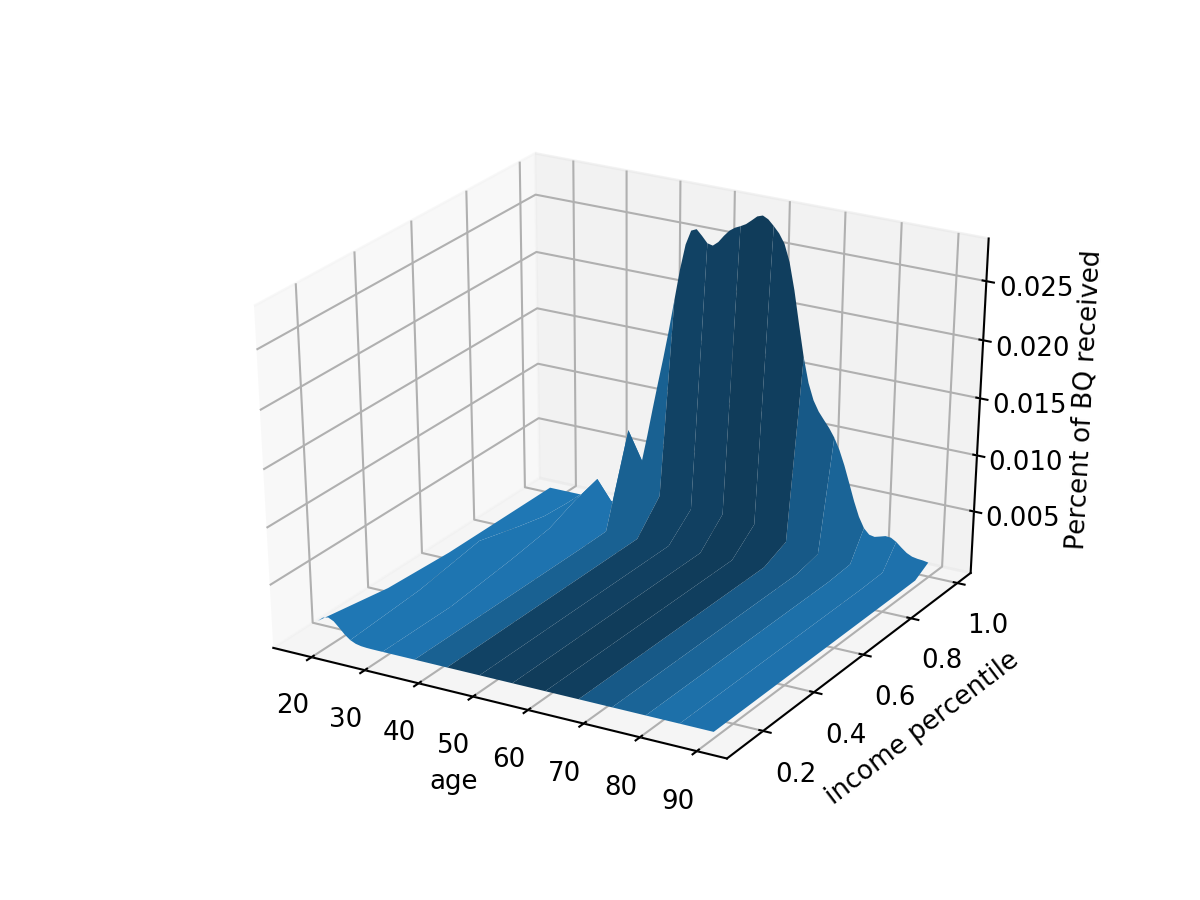

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, Z_scaled, rstride=6)
ax.set_xlabel('age')
ax.set_ylabel('income percentile')
ax.set_zlabel('Percent of BQ received');

I choose $\lambda = 0.2$ because it generates a smooth surface,indicating that it is not overfitting. Besides, We can see a peak in the top pencentile region, which is the same as the original shape of the density. It means that the model is not underfitting.

In [15]:
print(f'The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is {Z_scaled[61-18, 6-1]}.')

The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is 0.001683753458240057.
